# Tutorial 5 - Array Power

Este cuaderno muestra cómo utilizar pvlib para modelar la potencia de salida de un conjunto dada la irradiancia POA y la temperatura de la célula.


La física de una célula solar es bastante compleja.  Los modelos de la respuesta de una célula a la luz y la temperatura van desde aproximaciones de alto nivel que sólo necesitan uno o dos coeficientes, a modelos de circuitos eléctricos que requieren características más detalladas de la célula, a modelos completos de semiconductores basados en la física.  

El nivel de detalle debe ajustarse a la aplicación: las aproximaciones de primer orden pueden ser sorprendentemente precisas, pero probablemente no deberían utilizarse para tomar decisiones financieras, mientras que los modelos de semiconductores basados en la física rara vez son prácticos fuera de un entorno de laboratorio.

## Simple PVWatts array power

Aquí mostraremos uno de los modelos fotovoltaicos más básicos implementados por pvlib.  El modelo de módulo PVWatts sólo requiere dos parámetros: el tamaño de la matriz (capacidad nominal) y el cambio de eficiencia de la matriz con la temperatura de la célula.  Los tamaños típicos varían desde unos pocos kW en el caso de las instalaciones residenciales hasta cientos de MW en el caso de los grandes sistemas públicos.  El parámetro de respuesta de la célula a la temperatura, a menudo denominado coeficiente de temperatura del módulo, determina la pérdida de eficiencia cuando aumenta la temperatura.  Por ejemplo, un módulo que produce 100 W en condiciones de prueba, pero sólo 95 W cuando la temperatura de la célula aumenta 10 grados, tiene un coeficiente de temperatura de -0,5%/°C.  Los coeficientes de temperatura típicos oscilan entre -0,5%/°C y -0,2%/°C.


Leeremos los datos meteorológicos, ejecutaremos la transposición de la irradiancia y modelaremos la temperatura de la célula como en tutoriales anteriores:

In [1]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

0.9.4


In [2]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

location = pvlib.location.Location(latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
solar_position.index += pd.Timedelta('30min')

tracker_data = pvlib.tracking.singleaxis(solar_position['apparent_zenith'],
                                         solar_position['azimuth'],
                                         axis_azimuth=180,
                                         )
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

df_poa_tracker = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=azimuth,
                                                       dni=df_tmy['DNI'],
                                                       ghi=df_tmy['GHI'],
                                                       dhi=df_tmy['DHI'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(tracker_poa,
                                               df_tmy['DryBulb'],
                                               df_tmy['Wspd'],
                                               **parameters)

A efectos de demostración, supondremos un conjunto de 1 kW con un coeficiente de temperatura de -0,4%/°C:

In [3]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 1e3

array_power = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, gamma_pdc)

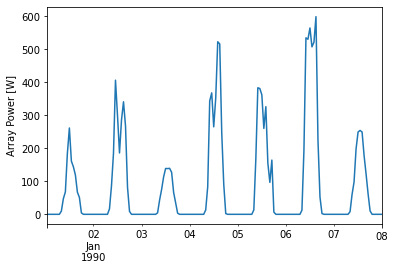

In [4]:
array_power.head(24*7).plot()
plt.ylabel('Array Power [W]');

Veamos la respuesta del conjunto o arreglo a la irradiancia y la temperatura:

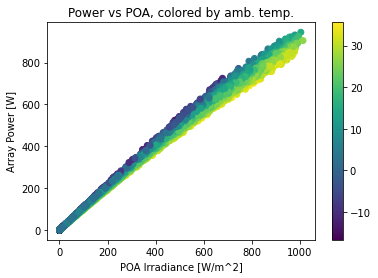

In [5]:
plt.scatter(tracker_poa, array_power, c=df_tmy['DryBulb'])
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

La Figura anterior muestra una fuerte tendencia casi lineal de la potencia con la irradiancia POA.  Sin embargo, también muestra un cambio de rendimiento con la temperatura: a medida que aumenta la temperatura ambiente, disminuye la producción del arreglo. El gradiente es más suave si coloreamos por temperatura de célula PV:

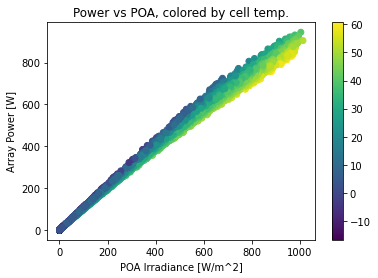

In [6]:
plt.scatter(tracker_poa, array_power, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by cell temp.');

Se puede hacer una comparacion con un módulo hipotético, que tiene un coeficiente de temperatura menor, que muestra un efecto de temperatura correspondientemente menor:

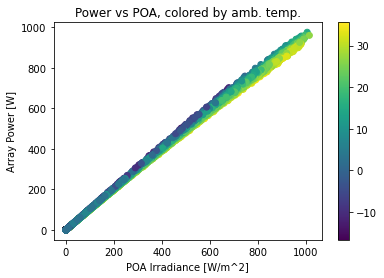

In [7]:
array_power_low_tempco = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, -0.002)
plt.scatter(tracker_poa, array_power_low_tempco, c=df_tmy['DryBulb'])
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by amb. temp.');

Otra forma de ver el efecto de la temperatura es comparar la producción mensual de energía con la insolación mensual del POA, observando cómo la producción disminuye en relación con la insolación en verano. En la siguiente Figura puede darse cuenta que la insolación y la producción son muy similares, y estan mas o menos a la misma escala; Esto fue por pura coincidencia, debido al tamaño del conjunto con el que estamos trabajando.

Text(0, 0.5, 'Energia [Wh]')

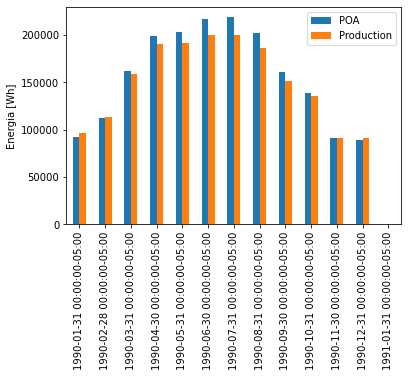

In [7]:
df_plot = pd.DataFrame({
    'POA': tracker_poa,
    'Production': array_power,
})
# summing hourly power (W) gives (W h)
df_plot.resample('M').sum().plot.bar()
plt.ylabel('Energia [Wh]')

## AC/DC

PVWatts tiene un modelo de inversor simplificado. Utilice [`pvlib.inverter.pvwatts(pdc, pdc0)`](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.inverter.pvwatts.html), para obtener la salida de CA dada la salida de CC, `pdc`, y el límite de CC, `pdc0`, que es la potencia nominal de CA sobre la eficiencia nominal del inversor.

Recordemos que asumimos una matriz de 1 kW, así que continuaremos con el caso hipotético y asumiremos un tamaño de CA de 800 W, una relación CC/CA de 1,2. La eficiencia nominal por defecto del inversor de PVWatts es de 0,96, que utilizaremos para obtener `pdc0`.

In [8]:
pdc0 = 800/0.96  # W
ac = pvlib.inverter.pvwatts(array_power, pdc0)

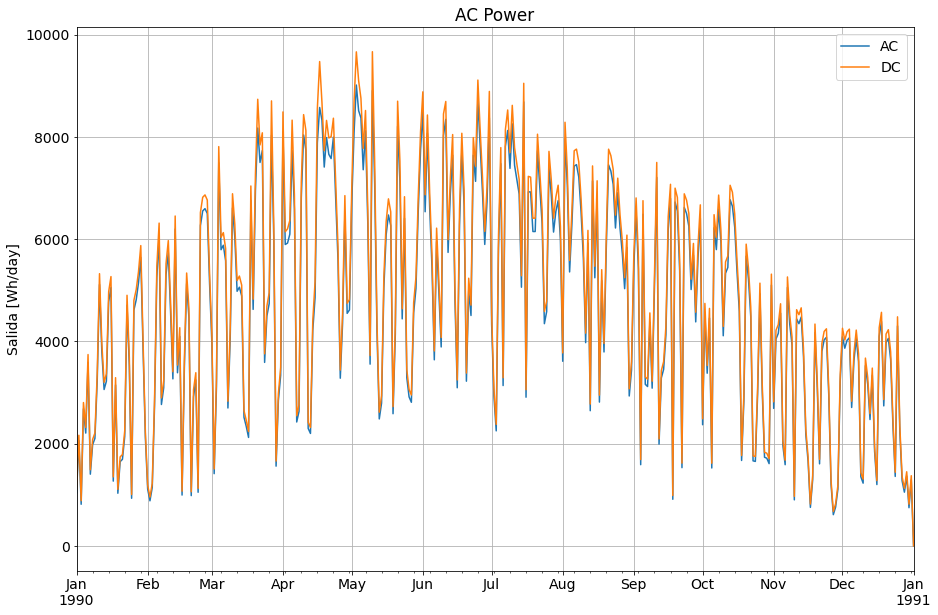

In [10]:
plt.rcParams['font.size'] = 14
ax = ac.resample('D').sum().plot(figsize=(15, 10), label='AC')
array_power.resample('D').sum().plot(ax=ax, label='DC')
plt.title('AC Power')
plt.ylabel('Salida [Wh/day]')
plt.grid()
plt.legend()

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).